# Location Forecast Figures with Flag Probability

This notebook generates:
1. **Spaghetti + Rainfall plot**: Ensemble predictions with rainfall bars
2. **Flag Probability plot** (ISIS & Godstow only): Probability of each flag at every time point

Data loading and plotting are separated so you can tweak plots without re-fetching data.

In [18]:
# Imports and setup
from __future__ import annotations

import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# Project / import setup
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from flag_predictor import get_location_config
from flag_predictor.config import (
    FLAG_COLORS,
    LOCATIONS,
    RAINFALL_STATION_NAMES,
    WALLINGFORD_RAINFALL_STATION_NAMES,
    get_flag_thresholds,
)
from flag_predictor.data.api import get_rainfall_forecast_ensemble
from flag_predictor.models import load_model
from flag_predictor.pipeline import prepare_training_data
from flag_predictor.prediction import predict_ensemble

# Global plot style
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["font.size"] = 11

print(f"Project root: {PROJECT_ROOT}")
print(f"Locations available: {list(LOCATIONS.keys())}")

Project root: /Users/robertds413/Documents/Flag_Predictor
Locations available: ['isis', 'godstow', 'wallingford']


In [37]:
# Helper utilities

def get_location_station_names(location: str) -> list[str]:
    """Get the correct rainfall station names for a given location."""
    location_lower = location.lower()
    if location_lower == "wallingford":
        return list(RAINFALL_STATION_NAMES) + list(WALLINGFORD_RAINFALL_STATION_NAMES)
    elif location_lower == "godstow":
        return [s for s in RAINFALL_STATION_NAMES if s not in {"Bicester", "Grimsbury"}]
    else:
        return list(RAINFALL_STATION_NAMES)


def _ensure_timezone_naive(index: pd.Index) -> pd.Index:
    """Make a DatetimeIndex timezone-naive if needed."""
    if hasattr(index, "tz") and index.tz is not None:
        return index.tz_localize(None)
    return index


def _short_date(x, pos=None):
    """Format date as 'Wed 4 May' style."""
    d = mdates.num2date(x)
    return d.strftime("%a ") + str(d.day) + "\n " + d.strftime("%b")


class _MiddayLocator(mdates.DayLocator):
    """Place ticks at midday (12h) instead of midnight."""
    def tick_values(self, vmin, vmax):
        ticks = super().tick_values(vmin, vmax)
        return [t + 0.5 for t in ticks]


def calculate_flag_probabilities(ensemble_predictions: pd.DataFrame, flag_thresholds: dict) -> pd.DataFrame:
    """Calculate the probability of each flag at every time point."""
    n_members = len(ensemble_predictions.columns)
    flag_probs = pd.DataFrame(index=ensemble_predictions.index)
    for flag_name, (lower, upper) in flag_thresholds.items():
        in_range = ((ensemble_predictions >= lower) & (ensemble_predictions < upper)).sum(axis=1)
        flag_probs[flag_name] = in_range / n_members
    return flag_probs

In [88]:
@dataclass
class LocationData:
    """Container for all data needed to plot a location's forecast."""
    location: str
    flag_thresholds: dict
    
    # Ensemble predictions (columns = members, index = forecast times)
    ensemble_predictions: pd.DataFrame
    ensemble_stats: pd.DataFrame  # mean, std, min, max
    n_members: int
    
    # Historical data
    historical_df: pd.DataFrame  # last N days of merged data with 'differential' column
    
    # Rainfall data
    historical_rainfall_daily: pd.Series
    forecast_rain_mean: pd.Series
    forecast_rain_p10: pd.Series
    forecast_rain_p90: pd.Series
    
    # Key timestamps
    forecast_start_time: pd.Timestamp


def load_location_data(
    location: str,
    n_members: int = 50,
    historical_days: int = 8,
    project_root: Path | None = None,
) -> LocationData:
    """
    Load all data needed for plotting a location's forecast.
    
    Args:
        location: 'isis', 'godstow', or 'wallingford'
        n_members: Number of ensemble members
        historical_days: Number of days of historical data to include
        project_root: Path to project root
    
    Returns:
        LocationData object containing all data needed for plotting
    """
    project_root = project_root or PROJECT_ROOT

    print(f"\n{'=' * 80}")
    print(f"LOADING DATA FOR: {location.upper()}")
    print(f"{'=' * 80}")

    flag_thresholds = get_flag_thresholds(location)
    station_names_list = get_location_station_names(location)

    # ------------------------------------------------------------------
    # STEP 1: Historical data
    # ------------------------------------------------------------------
    print("\nStep 1: Loading historical data...")
    merged_df, X, y_multi = prepare_training_data(
        location=location,
        project_root=project_root,
        verbose=True,
    )

    # ------------------------------------------------------------------
    # STEP 2: Load model
    # ------------------------------------------------------------------
    print("\nStep 2: Loading model...")
    models_dir = project_root / "models"
    model_path = models_dir / f"multihorizon_model_experiment_2026_01_{location}.pth"
    scaler_path = models_dir / f"scaler_experiment_2026_01_{location}.pkl"
    config_path = models_dir / f"config_experiment_2026_01_{location}.pkl"

    model, scaler, model_config = load_model(
        model_path=str(model_path),
        scaler_path=str(scaler_path),
        config_path=str(config_path),
    )

    feature_columns = model_config["feature_columns"]
    sequence_length = model_config["sequence_length"]
    horizons = model_config["horizons"]

    print(f"  Model loaded: seq_len={sequence_length}, features={len(feature_columns)}")

    # ------------------------------------------------------------------
    # STEP 3: Fetch ensemble rainfall forecast
    # ------------------------------------------------------------------
    print(f"\nStep 3: Fetching rainfall forecast...")
    rainfall_forecast = get_rainfall_forecast_ensemble(
        location=location,
        n_members=n_members,
    )
    print(f"  ✓ Rainfall forecast: {rainfall_forecast.shape}")

    # ------------------------------------------------------------------
    # STEP 4: Ensemble prediction
    # ------------------------------------------------------------------
    print(f"\nStep 4: Running ensemble prediction...")
    ensemble_predictions = predict_ensemble(
        model=model,
        scaler=scaler,
        historical_df=merged_df,
        rainfall_ensemble_df=rainfall_forecast,
        feature_columns=feature_columns,
        sequence_length=sequence_length,
        horizons=horizons,
        station_names=station_names_list,
        n_members=n_members,
        verbose=True,
    )

    # ------------------------------------------------------------------
    # STEP 5: Process data for plotting
    # ------------------------------------------------------------------
    print(f"\nStep 5: Processing data...")
    
    # Make timezone-naive
    plot_df = ensemble_predictions.copy()
    plot_df.index = _ensure_timezone_naive(plot_df.index)

    # Ensemble statistics
    plot_stats = pd.DataFrame({
        "mean": plot_df.mean(axis=1),
        "std": plot_df.std(axis=1),
        "min": plot_df.min(axis=1),
        "max": plot_df.max(axis=1),
    })

    n_members_used = len(ensemble_predictions.columns)

    # Historical data (last N days)
    hist_merged = merged_df.copy()
    hist_merged.index = _ensure_timezone_naive(hist_merged.index)
    historical_df = hist_merged.iloc[-24 * historical_days:].copy()

    # Historical rainfall
    rainfall_cols = [col for col in historical_df.columns if col in station_names_list]
    historical_rainfall_hourly = historical_df[rainfall_cols].mean(axis=1)
    historical_rainfall_daily = historical_rainfall_hourly.resample("1D").sum()

    # Forecast rainfall
    rainfall_forecast_naive = rainfall_forecast.copy()
    rainfall_forecast_naive.index = _ensure_timezone_naive(rainfall_forecast_naive.index)

    member_totals = pd.DataFrame(index=rainfall_forecast_naive.index)
    for member_idx in range(n_members_used):
        member_cols = [f"{station}_member_{member_idx}" for station in station_names_list]
        existing_cols = [col for col in member_cols if col in rainfall_forecast_naive.columns]
        if existing_cols:
            member_totals[f"member_{member_idx}"] = rainfall_forecast_naive[existing_cols].mean(axis=1)

    member_totals_daily = member_totals.resample("1D").sum()
    forecast_rain_mean = member_totals_daily.mean(axis=1)
    forecast_rain_p10 = member_totals_daily.quantile(0.10, axis=1)
    forecast_rain_p90 = member_totals_daily.quantile(0.90, axis=1)

    forecast_start_time = plot_df.index[0]

    print(f"  ✓ Data ready: {len(historical_df)} historical hours, {len(plot_df)} forecast hours")

    return LocationData(
        location=location,
        flag_thresholds=flag_thresholds,
        ensemble_predictions=plot_df,
        ensemble_stats=plot_stats,
        n_members=n_members_used,
        historical_df=historical_df,
        historical_rainfall_daily=historical_rainfall_daily,
        forecast_rain_mean=forecast_rain_mean,
        forecast_rain_p10=forecast_rain_p10,
        forecast_rain_p90=forecast_rain_p90,
        forecast_start_time=forecast_start_time,
    )

In [172]:
def plot_location_figures(
    data: LocationData,
    show_historical: bool = True,
) -> None:
    """
    Plot the spaghetti + rainfall figure AND probability plot for a location.
    
    Args:
        data: LocationData object from load_location_data()
        show_historical: If True, include historical data in x-limits. 
                        If False, only show forecast period.
    """
    location = data.location
    flag_thresholds = data.flag_thresholds
    plot_df = data.ensemble_predictions
    plot_stats = data.ensemble_stats
    n_members_used = data.n_members
    historical_df = data.historical_df
    forecast_start_time = data.forecast_start_time

    # Rainfall data
    historical_rainfall_daily = data.historical_rainfall_daily
    forecast_rain_mean = data.forecast_rain_mean
    error_lower = forecast_rain_mean - data.forecast_rain_p10
    error_upper = data.forecast_rain_p90 - forecast_rain_mean

    # Determine x-limits
    if show_historical:
        xlim = (historical_df.index[0], plot_df.index[-1])
    else:
        xlim = (plot_df.index[0], plot_df.index[-1])

    # Extend historical data to forecast start if needed
    historical_to_plot = historical_df.copy()
    if historical_to_plot.index[-1] < forecast_start_time:
        gap_times = pd.date_range(
            start=historical_to_plot.index[-1] + pd.Timedelta(hours=1),
            end=forecast_start_time,
            freq="1h",
        )
        gap_data = pd.Series(
            [historical_to_plot["differential"].iloc[-1]] * len(gap_times),
            index=gap_times,
        )
        historical_to_plot = pd.concat([
            historical_to_plot,
            pd.DataFrame({"differential": gap_data}),
        ])
    elif historical_to_plot.index[-1] > forecast_start_time:
        historical_to_plot = historical_to_plot[historical_to_plot.index <= forecast_start_time]

    # ------------------------------------------------------------------
    # Create figures
    # ------------------------------------------------------------------
    show_prob_plot = location.lower() != "wallingford"
    
    if show_prob_plot:
        # Calculate the fraction where "Now" falls in the x-axis
        total_duration = (plot_df.index[-1] - historical_df.index[0]).total_seconds()
        now_fraction = (forecast_start_time - historical_df.index[0]).total_seconds() / total_duration
        
        fig, (ax, ax_prob) = plt.subplots(2, 1, figsize=(22, 15), height_ratios=[2, 1])
    else:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax_prob = None
        now_fraction = None

    ax_rain = ax.twinx()

    # ============= SPAGHETTI PLOT =============
    # Flag boundaries
    if location.lower() != "wallingford":
        ax.axhspan(-4, flag_thresholds["light_blue"][0], color=FLAG_COLORS["green"], alpha=0.08, zorder=0)
        ax.axhspan(flag_thresholds["light_blue"][0], flag_thresholds["dark_blue"][0], color=FLAG_COLORS["light_blue"], alpha=0.08, zorder=0)
        ax.axhspan(flag_thresholds["dark_blue"][0], flag_thresholds["amber"][0], color=FLAG_COLORS["dark_blue"], alpha=0.08, zorder=0)
        ax.axhspan(flag_thresholds["amber"][0], flag_thresholds["red"][0], color=FLAG_COLORS["amber"], alpha=0.08, zorder=0)
        ax.axhspan(flag_thresholds["red"][0], 4, color=FLAG_COLORS["red"], alpha=0.08, zorder=0)

    # Rainfall bars
    bar_width = 0.8
    bar_center_offset = pd.Timedelta(hours=12)

    ax_rain.bar(
        historical_rainfall_daily.index + bar_center_offset,
        historical_rainfall_daily.values,
        width=bar_width, color="gray", alpha=0.4,
        label="Historical Rainfall", zorder=1,
    )

    ax_rain.bar(
        forecast_rain_mean.index + bar_center_offset,
        forecast_rain_mean.values,
        width=bar_width, color="cornflowerblue", alpha=0.5,
        yerr=[error_lower.values, error_upper.values],
        error_kw={"elinewidth": 1.5, "capsize": 3, "capthick": 1, "alpha": 0.7, "color": "navy"},
        label="Forecast Rainfall (mean ± P10-P90)", zorder=2,
    )

    # Historical differential
    ax.plot(
        historical_to_plot.index,
        historical_to_plot["differential"].values,
        color="black", linewidth=3,
        label="Historical Differential", zorder=100, alpha=0.9,
    )

    # Current time marker
    ax.axvline(x=forecast_start_time, color="red", linestyle="--", linewidth=2.5, alpha=0.8, label="Now", zorder=101)

    # Ensemble spaghetti
    for idx, col in enumerate(plot_df.columns):
        label = f"Ensemble Predictions (n={n_members_used})" if idx == 0 else None
        ax.plot(plot_df.index, plot_df[col].values, color="steelblue", linewidth=1.2, alpha=0.5, label=label, zorder=50)

    # Ensemble mean
    ax.plot(plot_df.index, plot_stats["mean"].values, color="darkviolet", linewidth=3, label="Ensemble Mean", zorder=102, alpha=1)

    # Formatting
    ax.set_ylabel("Height Differential (m)", fontsize=20, fontweight="bold", color="black")
    ax_rain.set_ylabel("Rainfall (mm/day, avg across stations)", fontsize=20, fontweight="bold", color="cornflowerblue")
    ax.tick_params(axis="both", labelsize=16, labelcolor="black")
    ax_rain.tick_params(axis="y", labelsize=16, labelcolor="cornflowerblue")
    ax.set_ylim(-0.1, max(1.1, plot_stats["max"].max() + 0.1))
    max_rain = max(historical_rainfall_daily.max(), data.forecast_rain_p90.max()) if len(data.forecast_rain_p90) > 0 else historical_rainfall_daily.max()
    ax_rain.set_ylim(0, max_rain * 1.3)
    ax.set_title(f"{location.upper()}", fontsize=32, fontweight="bold", pad=20)
    ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.8)

    # Collect legend handles for later placement
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_rain.get_legend_handles_labels()
    legend_handles = lines1 + lines2
    legend_labels = labels1 + labels2

    # Day markers
    for i in range(1, 11):
        day_time = forecast_start_time + pd.Timedelta(days=i)
        if day_time <= plot_df.index[-1]:
            ax.axvline(x=day_time, color="gray", linestyle=":", alpha=0.3, zorder=0)

    # ============= FLAG PROBABILITY PLOT =============
    if show_prob_plot and ax_prob is not None:
        flag_probs = calculate_flag_probabilities(plot_df, flag_thresholds)
        
        if location.lower() == "godstow":
            flag_order = ["green", "amber", "red"]
        else:
            flag_order = ["green", "light_blue", "dark_blue", "amber", "red"]
        
        colors = [FLAG_COLORS[f] for f in flag_order]
        probs = [flag_probs[f].values for f in flag_order]
        
        ax_prob.stackplot(
            flag_probs.index,
            *probs,
            labels=[f.replace("_", " ").title() for f in flag_order],
            colors=colors,
            alpha=0.8,
        )
        
        ax_prob.axvline(x=forecast_start_time, color="red", linestyle=":", linewidth=2.5, alpha=0.8, zorder=101)
        
        ax_prob.set_ylabel("Future Flag Probability", fontsize=20, fontweight="bold", labelpad=20, va = "center")
        # ax_prob.set_xlabel("Date", fontsize=20, fontweight="bold")
        ax_prob.set_ylim(0, 1)
        ax_prob.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax_prob.set_yticklabels(["0%", "25%", "50%", "75%", "100%"], fontweight="bold")
        ax_prob.tick_params(axis="both", labelsize=16)
        ax_prob.grid(True, alpha=0.3, linestyle=":", linewidth=0.8, axis="y")
        # ax_prob.set_title("Flag Probability Over Time", fontsize=20, fontweight="bold", pad=10)
        
        # Add vertical lines at midnight to delineate days
        first_midnight = forecast_start_time.normalize() + pd.Timedelta(days=1)
        for i in range(15):  # Cover up to 15 days
            midnight = first_midnight + pd.Timedelta(days=i)
            if midnight > plot_df.index[-1]:
                break
            ax_prob.axvline(x=midnight, color="black", linestyle="--", linewidth=1, alpha=0.5, zorder=50)
        
    # X-axis formatting for spaghetti plot
    ax.xaxis.set_major_locator(_MiddayLocator(interval=1))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(_short_date))
    ax.tick_params(axis='x', pad=13)  # Move date labels down slightly
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha="center", fontweight="bold")
    ax.set_xlim(xlim)
    
    # X-axis formatting for probability plot - ticks but no date labels (shown on plot above)
    if ax_prob is not None:
        ax_prob.set_xlim(forecast_start_time, plot_df.index[-1])
        ax_prob.xaxis.set_major_locator(_MiddayLocator(interval=1))
        ax_prob.xaxis.set_major_formatter(plt.NullFormatter())  # Hide date labels
        ax_prob.tick_params(axis='x', which='major', top=True, bottom=False)  # Ticks on top only
    

    plt.tight_layout()
    
    # Manually reposition probability plot to align axes box with "Now" line
    if ax_prob is not None and now_fraction is not None:
        fig.canvas.draw()  # Need to draw first to get accurate positions
        
        # Get the top plot's axes box position in figure coordinates
        top_bbox = ax.get_position()
        
        # Calculate x-position of "Now" within the top plot's axes box
        now_x = top_bbox.x0 + now_fraction * top_bbox.width
        
        # Get bottom plot's current position
        bottom_bbox = ax_prob.get_position()
        
        # Calculate new width (from "Now" to right edge of top plot)
        new_width = top_bbox.x0 + top_bbox.width - now_x
        
        # Set new position: left edge at "Now", same height, width to match right edge
        ax_prob.set_position([now_x, bottom_bbox.y0 + 0.005, new_width, bottom_bbox.height])
        
        # Place legend in the whitespace (bottom-left area) using figure coordinates
        fig.legend(legend_handles, legend_labels, fontsize=20,
                   loc="upper left", bbox_to_anchor=(top_bbox.x0 + 0.025, bottom_bbox.y0 + bottom_bbox.height - 0.04),
                   bbox_transform=fig.transFigure, framealpha=1, ncol=1)
    plt.show()

    print(f"✓ Figures displayed for {location.upper()}")

---
## ISIS

In [ ]:
# Load ISIS data (run once)
isis_data = load_location_data("isis", n_members=50, historical_days=8)


LOADING DATA FOR: ISIS

Step 1: Loading historical data...

Preparing training data for Isis Stretch
✓ Loaded Isis Stretch historical data: (216385, 1)
  Date range: 2017-02-04 12:00:00+00:00 to 2026-01-20 10:15:00+00:00
Filtering out Wallingford-specific stations for isis...
Loading historical rainfall data from 19 files...


KeyboardInterrupt: 

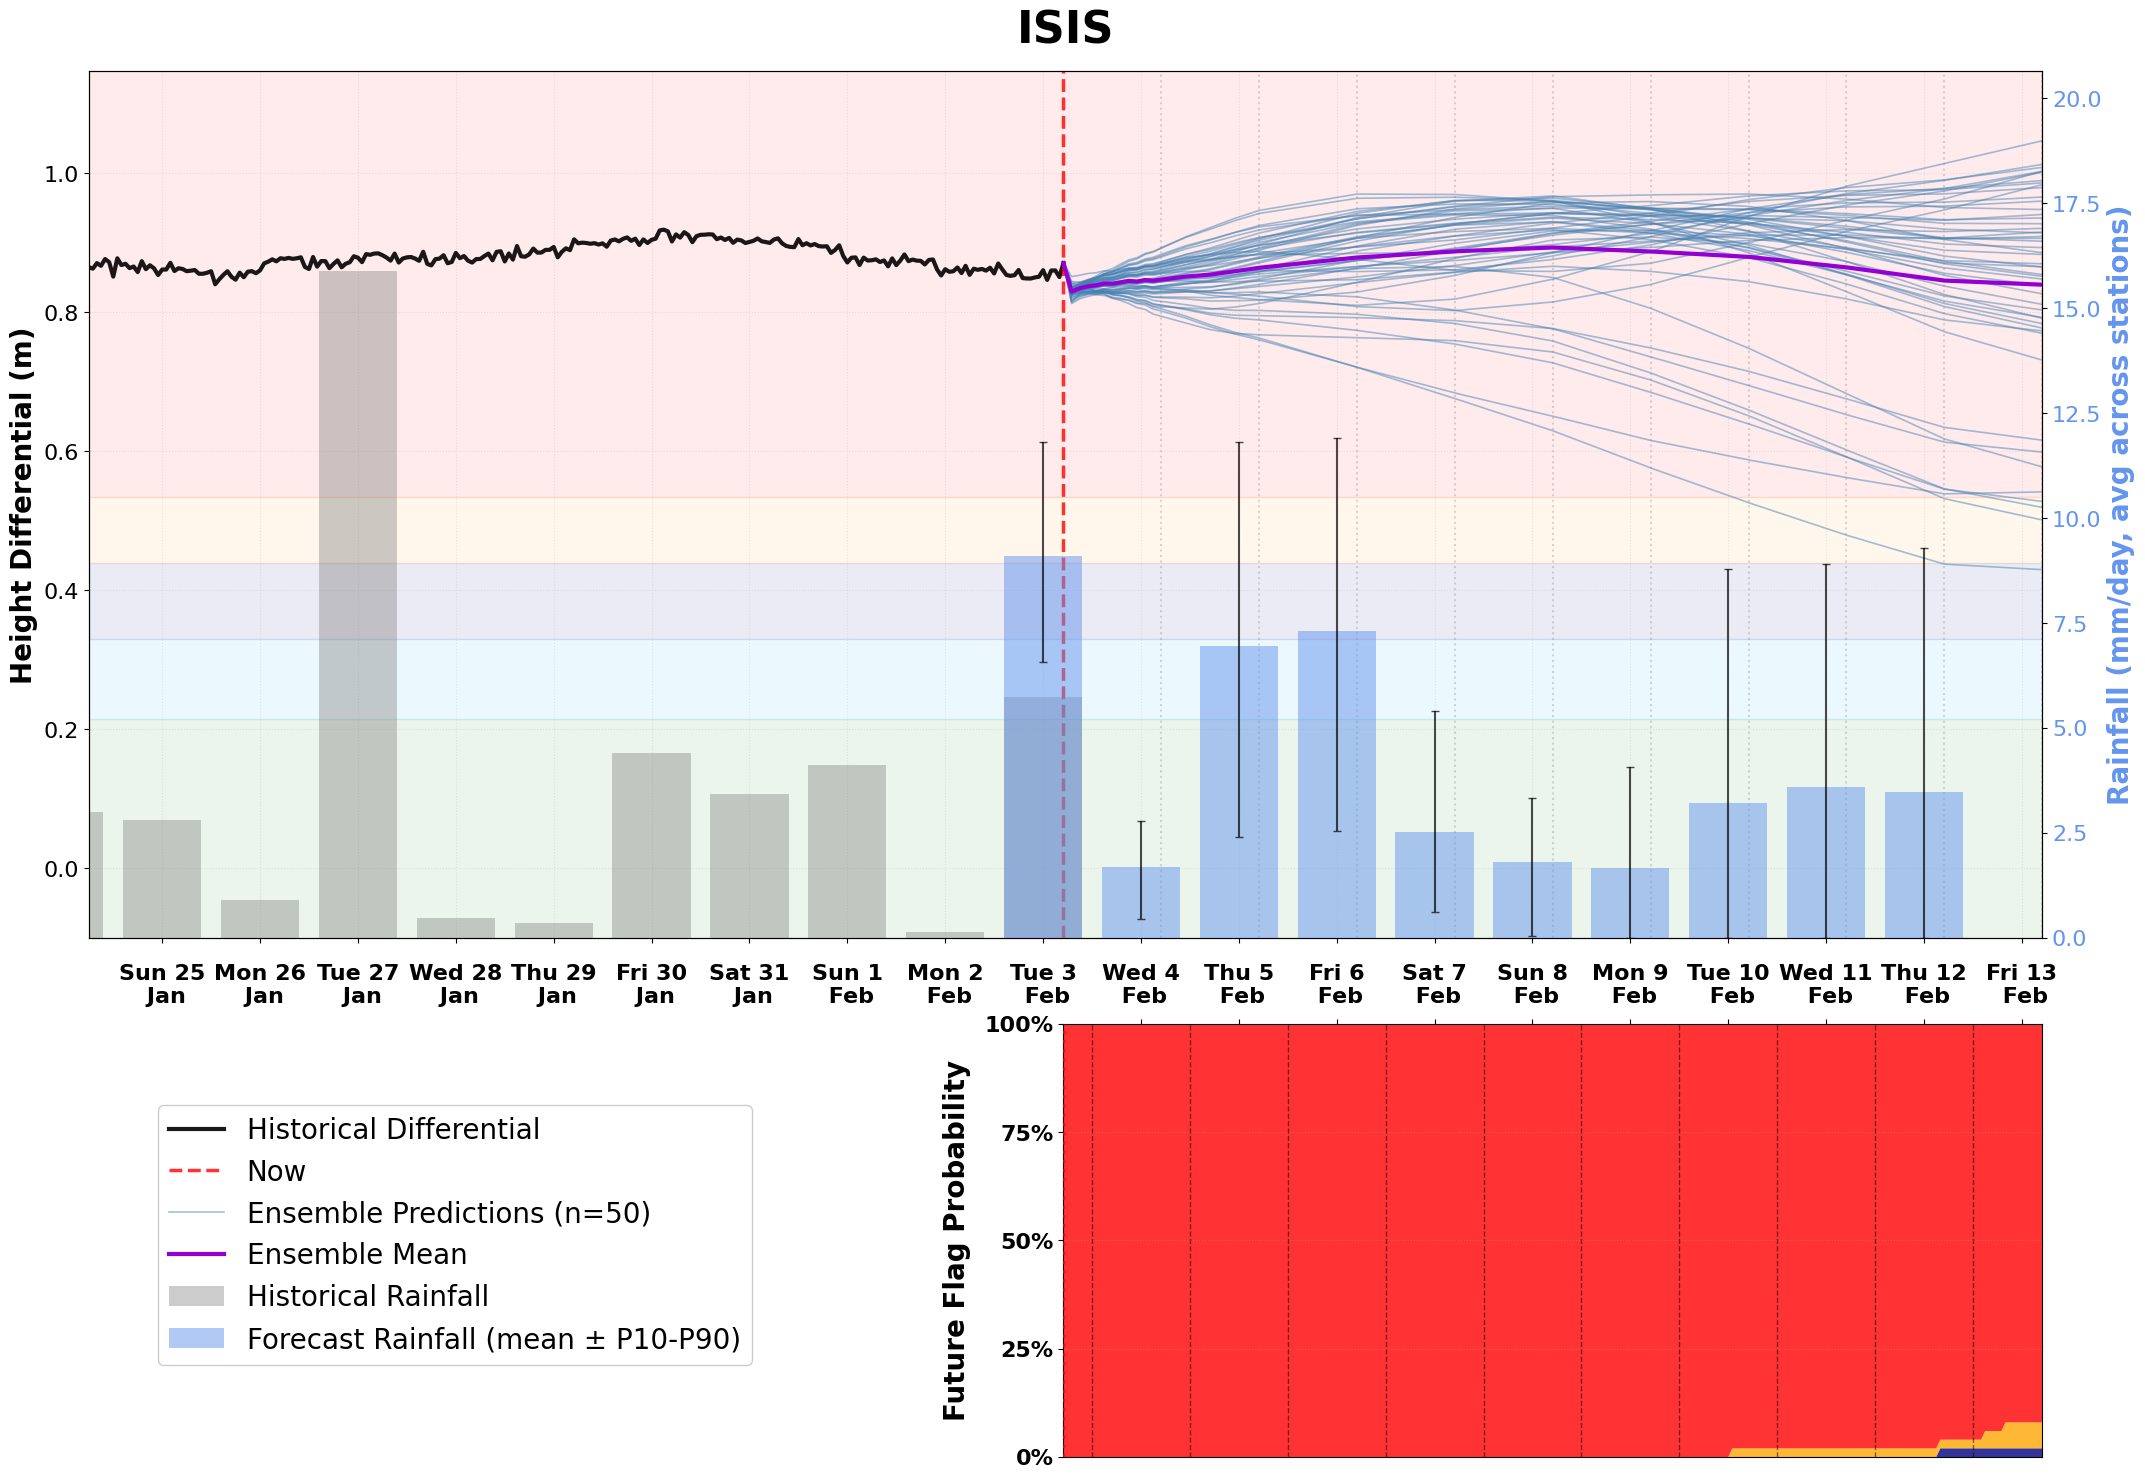

✓ Figures displayed for ISIS


In [170]:
# Plot ISIS (can re-run to tweak without reloading)
plot_location_figures(isis_data, show_historical=True)

---
## Godstow

In [159]:
# Load Godstow data (run once)
godstow_data = load_location_data("godstow", n_members=50, historical_days=8)


LOADING DATA FOR: GODSTOW

Step 1: Loading historical data...

Preparing training data for Godstow Stretch
✓ Loaded Godstow Stretch historical data: (196557, 1)
  Date range: 2017-01-01 00:00:00+00:00 to 2026-01-20 10:00:00+00:00
Filtering out Wallingford-specific stations for godstow...
Filtering out Bicester and Grimsbury for godstow...
Loading historical rainfall data from 19 files...

✓ Combined historical rainfall: (314534, 19)
  Date range: 2017-02-02 00:00:00 to 2026-01-22 09:00:00
Loading historical flow data from 1 files...
✓ Combined historical flow: (313863, 1)
  Date range: 2017-02-02 00:00:00 to 2026-01-15 09:30:00
Fetching river level data...
  ✓ kings_mill_downstream: 2853 records
  ✓ godstow_downstream: 2858 records
  ✓ osney_upstream: 2858 records
  ✓ osney_downstream: 2857 records
  ✓ iffley_upstream: 2858 records
  ✓ benson_downstream: 2858 records
  ✓ cleeve_upstream: 2858 records
Fetching rainfall data...
  Excluding Bicester and Grimsbury for Godstow
  ✓ Osney: 2

/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame i

Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 137
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 64564
Date range: 2017-02-02 01:00:00+00:00 to 2026-01-24 18:00:00+00:00

✓ Dropping 728 rows with NaNs in features/targets (after feature engineering)

Step 2: Loading model...
Using device: mps (Apple Silicon GPU)
✓ Model loaded from: /Users/robertds413/Documents/Flag_Predictor/models/multihorizon_model_experiment_2026_01_godstow.pth
✓ Scaler loaded from: /Users/robertds413/Documents/Flag_Predictor/models/scaler_experiment_2026_01_godstow.pkl
✓ Sequence length: 100
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
  Model loaded: seq_len=100, features=117

Step 3: Fetching rainfall forecast...
✓ Successfully fetched ensemble forecast: 11 stations × 50 members
  ✓ Rainfall forecast: (240, 55

Processing ensemble members:   0%|          | 0/50 [00:00<?, ?it/s]/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_pr


✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-02-03 18:00:00+00:00 to 2026-02-13 18:00:00+00:00

Step 5: Processing data...
  ✓ Data ready: 192 historical hours, 241 forecast hours


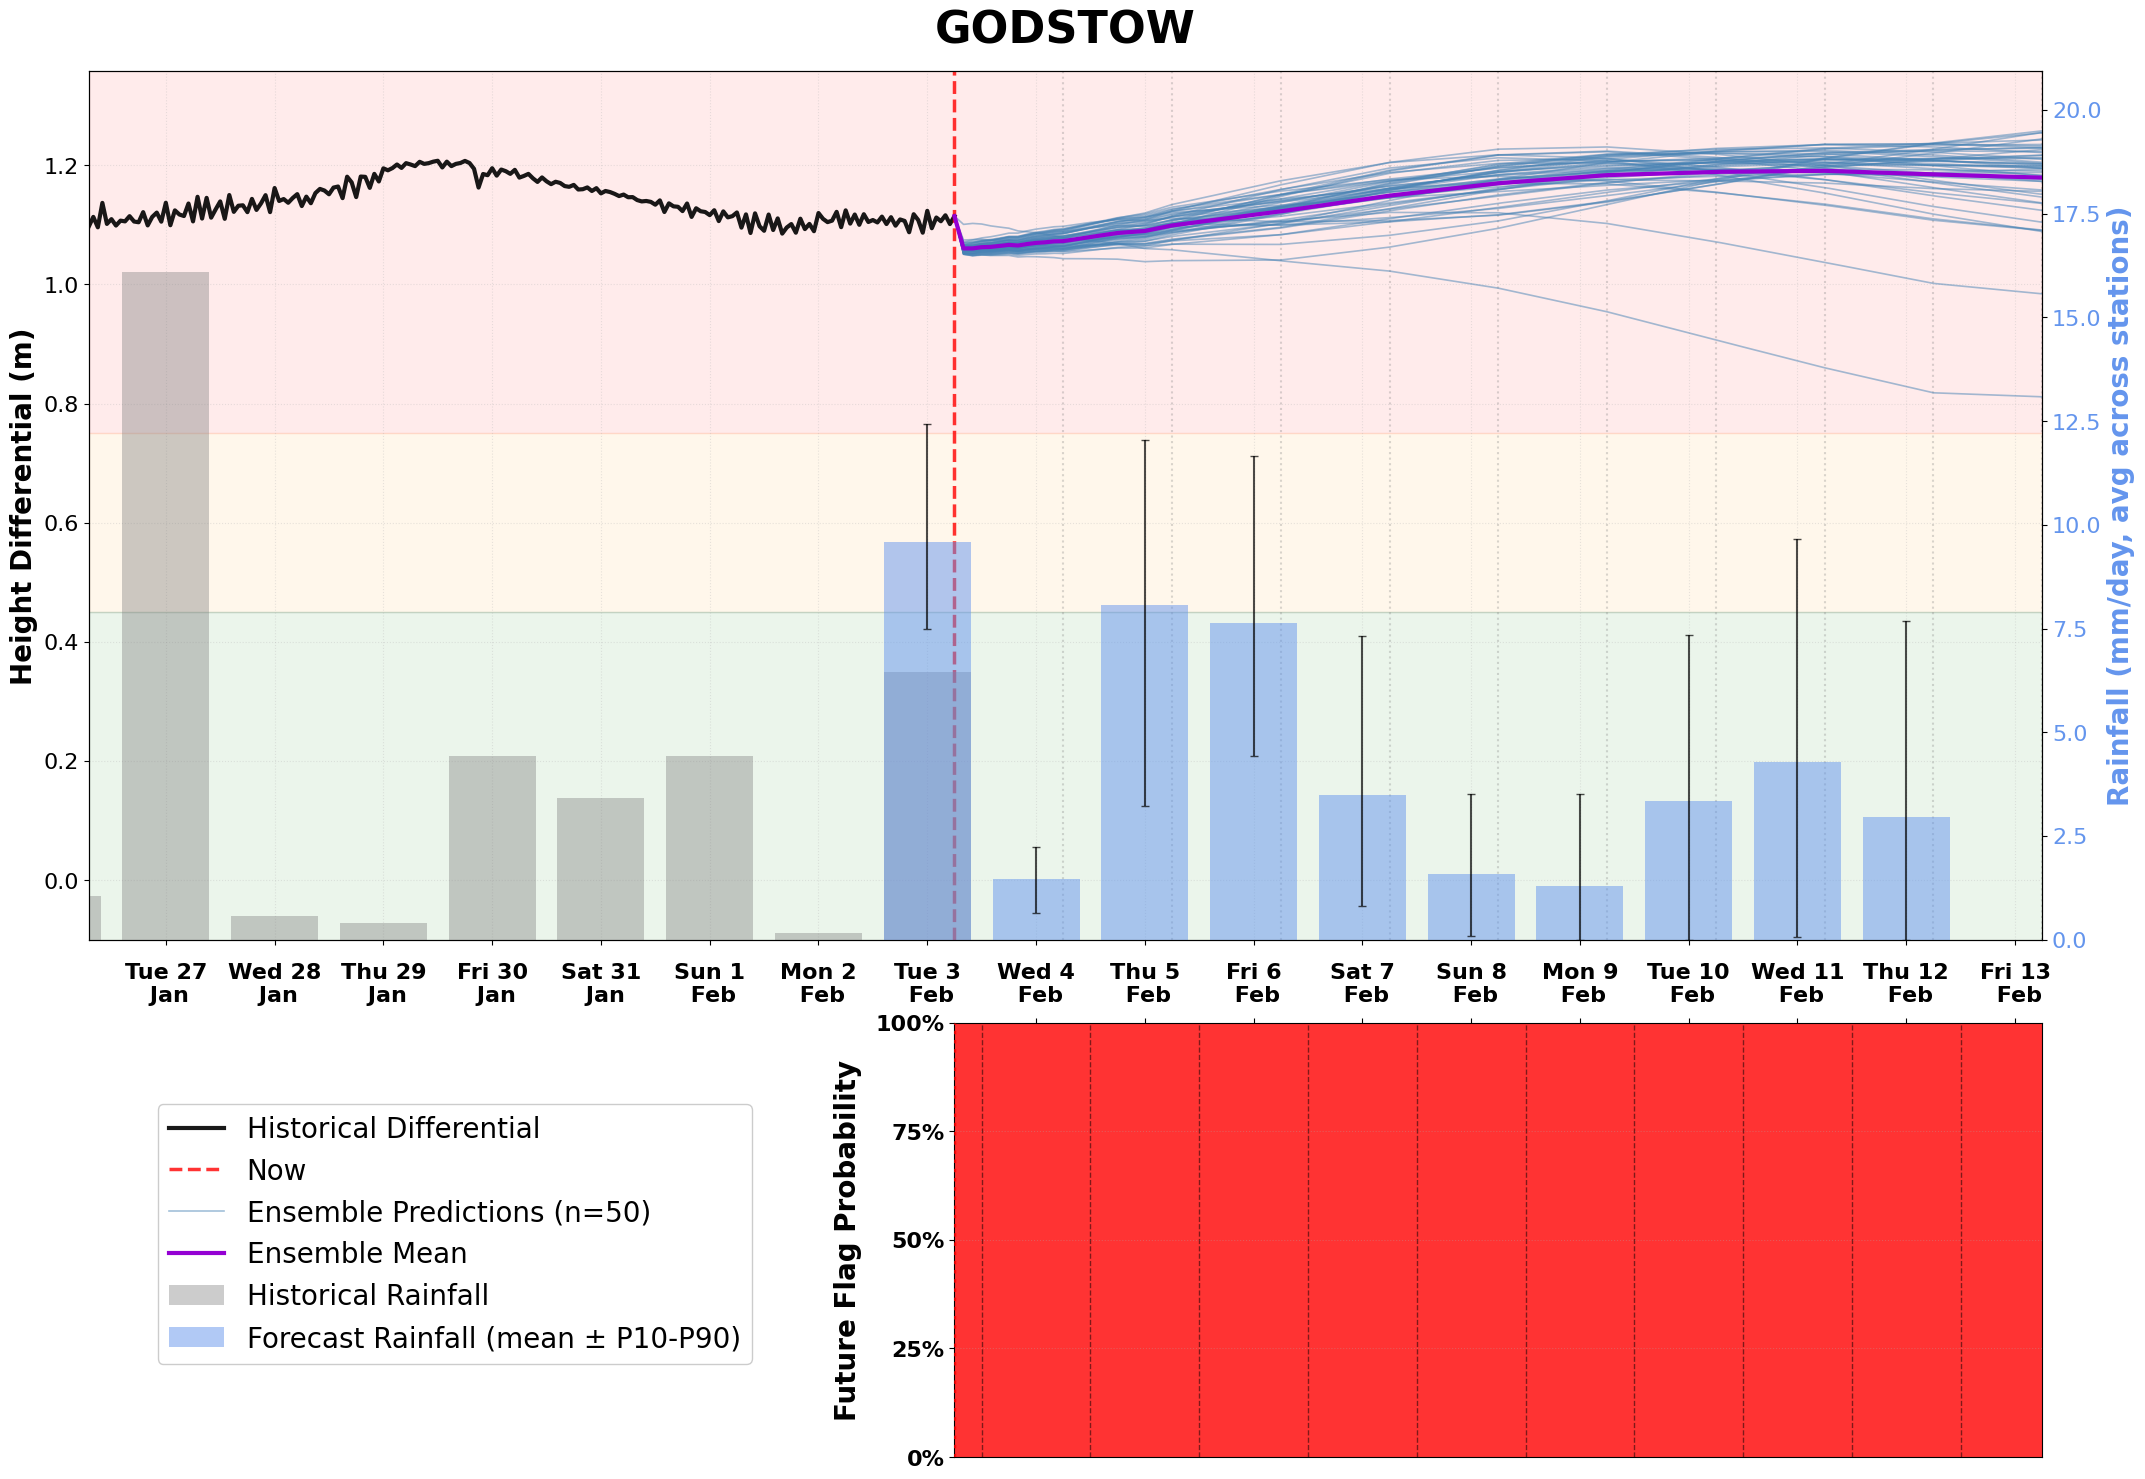

✓ Figures displayed for GODSTOW


In [174]:
# Plot Godstow (can re-run to tweak without reloading)
plot_location_figures(godstow_data, show_historical=True)

---
## Wallingford

Note: Wallingford does not have flag thresholds, so only the spaghetti plot is shown.

In [161]:
# Load Wallingford data (run once)
wallingford_data = load_location_data("wallingford", n_members=50, historical_days=8)


LOADING DATA FOR: WALLINGFORD

Step 1: Loading historical data...

Preparing training data for Wallingford Stretch
✓ Loaded Wallingford Stretch historical data: (191307, 1)
  Date range: 2020-02-13 20:30:00+00:00 to 2026-01-20 10:00:00+00:00
Loading historical rainfall data from 19 files...

✓ Combined historical rainfall: (314534, 19)
  Date range: 2017-02-02 00:00:00 to 2026-01-22 09:00:00
Loading historical flow data from 1 files...
✓ Combined historical flow: (313863, 1)
  Date range: 2017-02-02 00:00:00 to 2026-01-15 09:30:00
Fetching river level data...
  ✓ kings_mill_downstream: 2853 records
  ✓ godstow_downstream: 2858 records
  ✓ osney_upstream: 2858 records
  ✓ osney_downstream: 2857 records
  ✓ iffley_upstream: 2858 records
  ✓ benson_downstream: 2858 records
  ✓ cleeve_upstream: 2858 records
Fetching rainfall data...
  Including 6 Wallingford-specific stations
  ✓ Osney: 2858 records
  ✓ Eynsham: 2858 records
  ✓ St: 2209 records
  ✓ Shorncote: 2858 records
  ✓ Rapsgate: 2

/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:251: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: 

Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 139
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 50268
Date range: 2020-02-13 20:00:00+00:00 to 2026-01-24 18:00:00+00:00

✓ Dropping 728 rows with NaNs in features/targets (after feature engineering)

Step 2: Loading model...
Using device: mps (Apple Silicon GPU)
✓ Model loaded from: /Users/robertds413/Documents/Flag_Predictor/models/multihorizon_model_experiment_2026_01_wallingford.pth
✓ Scaler loaded from: /Users/robertds413/Documents/Flag_Predictor/models/scaler_experiment_2026_01_wallingford.pkl
✓ Sequence length: 100
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
  Model loaded: seq_len=100, features=125

Step 3: Fetching rainfall forecast...
✓ Successfully fetched ensemble forecast: 19 stations × 50 members
  ✓ Rainfall forecast: 

Processing ensemble members:   0%|          | 0/50 [00:00<?, ?it/s]/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:251: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/


✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-02-03 18:00:00+00:00 to 2026-02-13 18:00:00+00:00

Step 5: Processing data...
  ✓ Data ready: 192 historical hours, 241 forecast hours


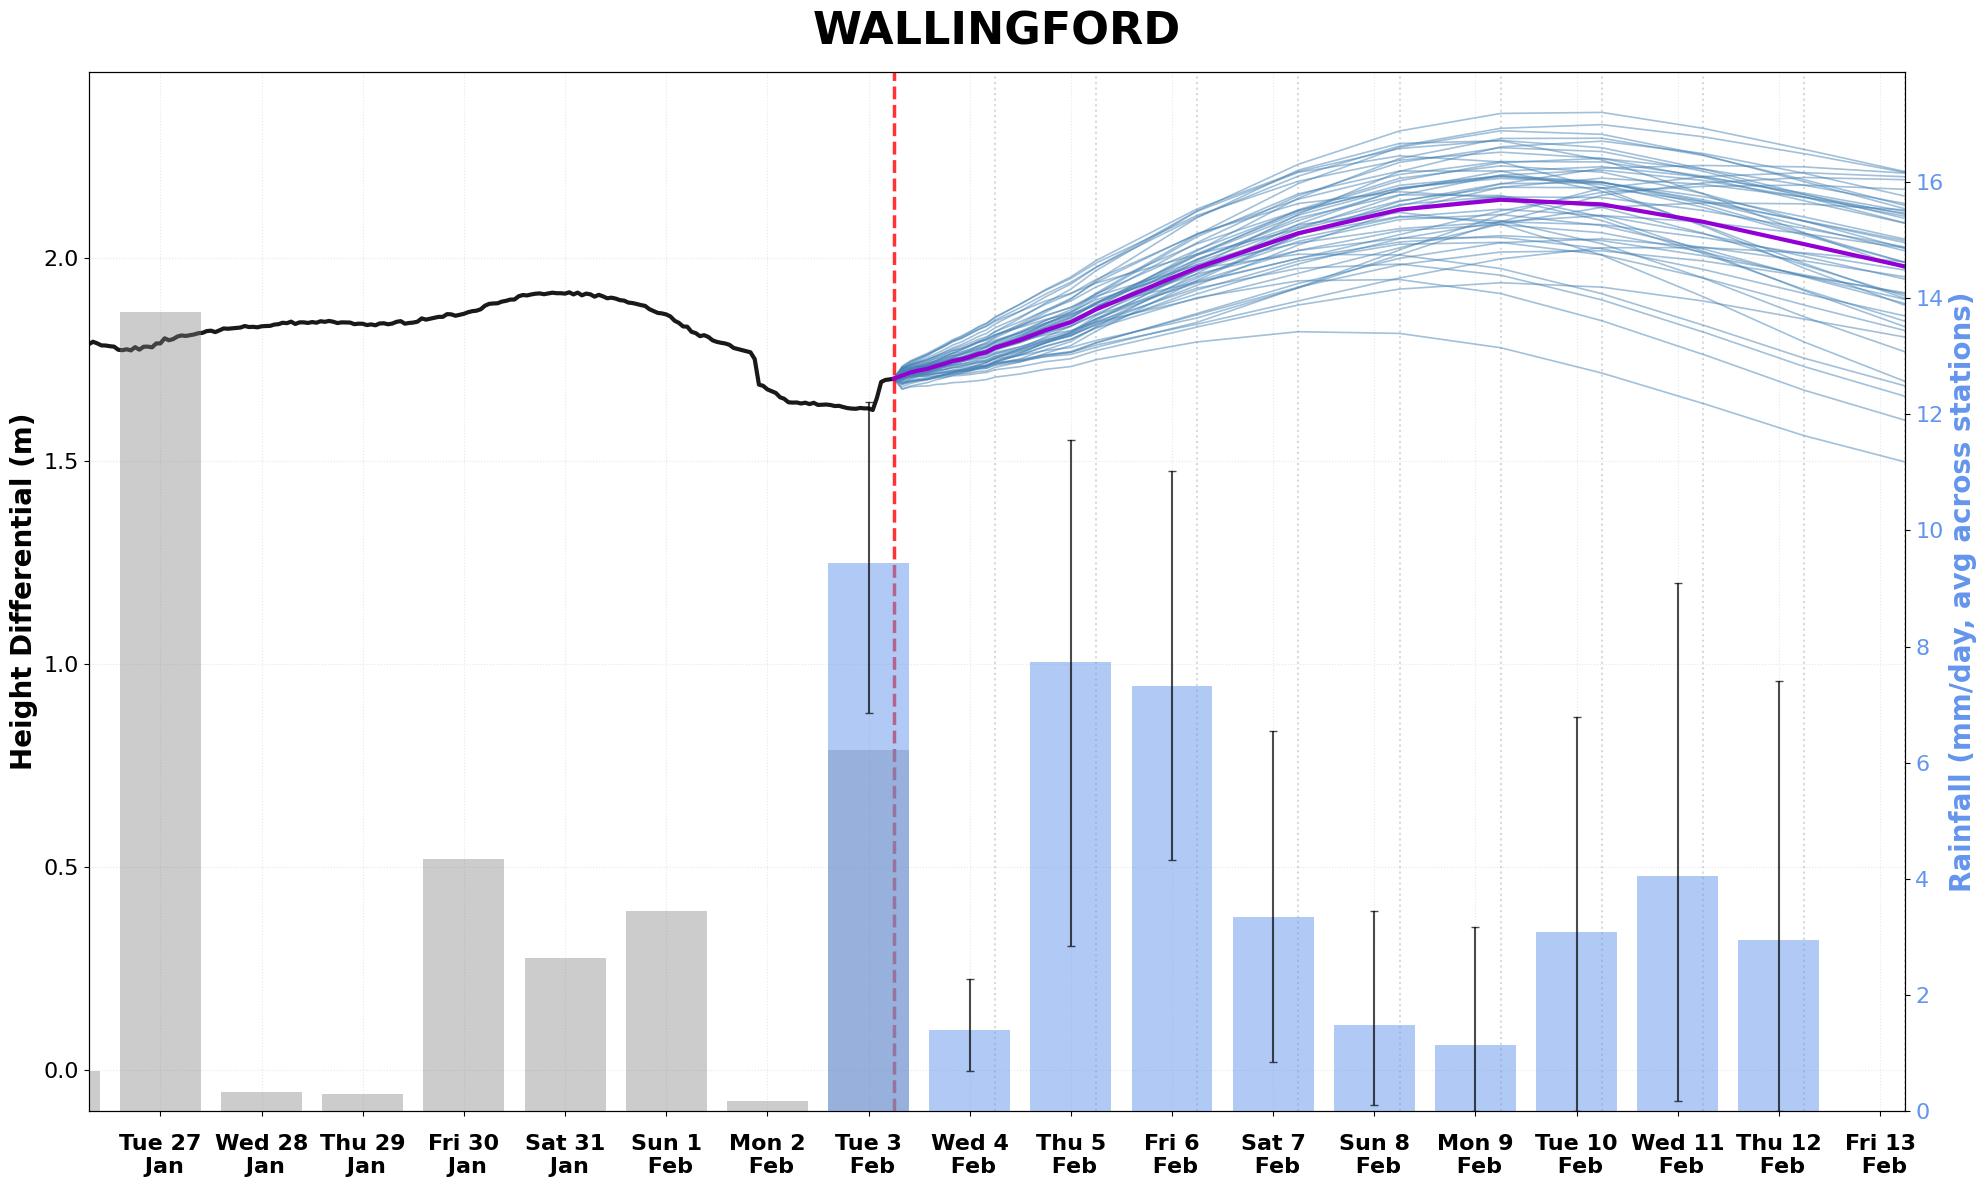

✓ Figures displayed for WALLINGFORD


In [175]:
# Plot Wallingford (can re-run to tweak without reloading)
plot_location_figures(wallingford_data, show_historical=True)